In [1]:
import os
import shutil
import sys
import os.path as osp
sys.path
sys.path.append('../../L1DeepMETv2/')
from graphmetnetwork import GraphMetNetwork

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.utils import to_undirected
from torch_cluster import radius_graph, knn_graph
from torch_geometric.datasets import MNISTSuperpixels
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from tqdm import tqdm
import model.net as net
import model.data_loader as data_loader
import utils

/nethome/dvsm3/.conda/envs/deepmet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Parameters

In [2]:
data_dir = '../../L1DeepMETv2/data_ttbar'
dataloaders = data_loader.fetch_dataloader(data_dir = data_dir, batch_size=1, validation_split=.2)
train_dl = dataloaders['train']
test_dl = dataloaders['test']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Training dataloader: {}, Test dataloader: {}'.format(len(train_dl), len(test_dl)))
print(device)

Processing...
0it [00:00, ?it/s]
Done!
/nethome/dvsm3/.conda/envs/deepmet/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Split: 199708
length of train/val data:  798834 199708
Training dataloader: 798834, Test dataloader: 199708
cuda


In [3]:
test_data = None
for cnt, test_data in enumerate(test_dl):
    if cnt == 5:
        break

In [4]:
test_data

DataBatch(x=[62, 8], edge_index=[2, 0], y=[1, 2], batch=[62], ptr=[2])

#### Load Tensor Parameters

In [5]:
n_features_cont = 6
x_cont_test = test_data.x[:,:n_features_cont] .to(device)  # include puppi
x_cat_test = test_data.x[:,n_features_cont:].long().to(device)
etaphi_test = torch.cat([test_data.x[:, 3][:, None], test_data.x[:, 4][:, None]], dim=1).to(device=device)
batch_test = test_data.batch.to(device)
edge_index_test = radius_graph(etaphi_test, r=0.4, batch=batch_test, loop=False, max_num_neighbors=255).to(device=device)
print(f'x_cont_test: {x_cont_test.shape}')
print(f'x_cat_test: {x_cat_test.shape}')
print(f'etaphi: {etaphi_test.shape}')
print(f'batch: {batch_test.shape}')
print(f'edge_index: {edge_index_test.shape}')

/nethome/dvsm3/.conda/envs/deepmet/lib/python3.10/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA RTX A6000 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA RTX A6000 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


x_cont_test: torch.Size([62, 6])
x_cat_test: torch.Size([62, 2])
etaphi: torch.Size([62, 2])
batch: torch.Size([62])
edge_index: torch.Size([2, 220])


In [6]:
print(batch_test)
print(test_data.y)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([[167.2438,  54.9883]])


#### Convert Tensor parameters to Numpy arrays

In [7]:
x_cont = np.ascontiguousarray(x_cont_test.squeeze(0).cpu().numpy())
x_cat = np.ascontiguousarray(x_cat_test.squeeze(0).cpu().numpy())
batch = np.ascontiguousarray(batch_test.squeeze(0).cpu().numpy())
etaphi = etaphi_test.squeeze(0).cpu().numpy()
edge_index = edge_index_test.squeeze(0).cpu().numpy().transpose()
num_nodes = x_cont.shape[0]
batch_size = batch.shape[0]
print(f'Number of nodes: {num_nodes}')
assert(num_nodes == batch_size)

Number of nodes: 62


### Load the Torch Model

In [8]:
prefix = '../../L1DeepMETv2/ckpts_April30_scale_sigmoid'
restore_ckpt = osp.join(prefix, 'last.pth.tar')
norm = torch.tensor([1., 1., 1., 1., 1., 1.]).to(device=device)
torch_model = net.Net(continuous_dim=6, categorical_dim=2 , norm=norm).to(device)
torch_model.eval()
print(torch_model)

Net(
  (graphnet): GraphMETNetwork(
    (embed_charge): Embedding(3, 8)
    (embed_pdgid): Embedding(7, 8)
    (embed_continuous): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): ELU(alpha=1.0)
    )
    (embed_categorical): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): ELU(alpha=1.0)
    )
    (encode_all): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ELU(alpha=1.0)
    )
    (bn_all): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_continuous): ModuleList(
      (0): ModuleList(
        (0): EdgeConv(nn=Sequential(
          (0): Linear(in_features=64, out_features=32, bias=True)
        ))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ModuleList(
        (0): EdgeConv(nn=Sequential(
          (0): Linear(in_features=64, out_features=32, bias=True)
        ))
     

/nethome/dvsm3/.conda/envs/deepmet/lib/python3.10/site-packages/torch_geometric/nn/conv/message_passing.py:988: UserWarning: 'EdgeConv.jittable' is deprecated and a no-op. Please remove its usage.
  warnings.warn(f"'{self.__class__.__name__}.jittable' is deprecated "


#### Get the weights

In [9]:
param_restored_new = utils.load_checkpoint(restore_ckpt, torch_model)
weights_dict = param_restored_new['state_dict']
print(weights_dict)

OrderedDict([('graphnet.embed_charge.weight', tensor([[ 0.9152, -1.0589, -0.9910,  0.0120, -1.2543,  0.2998, -0.3684, -0.0260],
        [ 1.1699, -1.1929, -0.4268, -0.7047, -0.3582,  0.5368,  1.0060, -0.7781],
        [-1.1897, -0.7680,  0.9429,  0.2915, -0.2274, -1.3632,  0.6982,  0.4960]],
       device='cuda:0')), ('graphnet.embed_pdgid.weight', tensor([[-2.0383, -0.3847, -0.2413,  0.9122, -0.4805,  0.2302, -0.4746,  0.9317],
        [-0.4117,  1.3556,  0.8550,  0.9977, -0.1622,  1.0582, -0.3220, -0.1858],
        [ 0.3344, -1.7237,  0.2500,  0.0249, -1.0838, -0.7614, -0.2512, -1.4239],
        [-0.0926,  0.4536, -0.2328,  1.5914, -0.3767, -1.6118,  0.4281,  0.3517],
        [-0.8126, -1.1399, -0.2381, -0.4232,  0.0113, -1.9791, -0.4646, -1.3267],
        [ 0.1623,  0.1171, -0.4400,  0.8133, -1.5196,  2.1547,  1.1111, -1.5128],
        [-2.0250,  0.8894,  1.1295, -1.7737, -1.0402, -1.3035, -0.5598, -0.0130]],
       device='cuda:0')), ('graphnet.embed_continuous.0.weight', tensor([[

In [10]:
output_dir = "weights_files/"

# Check if the directory exists
if os.path.exists(output_dir):
    # Iterate over all the files in the directory
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        try:
            # Check if it's a file and delete it
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            # If it's a directory, delete the directory and its contents
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")
else:
    print(f"Directory {output_dir} does not exist.")


# Function to save the weights as binary files
def save_weights_as_binary(weights_dict, output_dir):
    for key, tensor in weights_dict.items():
        # Convert the tensor to a NumPy array
        np_array = tensor.cpu().numpy()

        # Create a binary file name based on the tensor name
        file_name = output_dir + key.replace('.', '_') + '.bin'

        # Save the NumPy array as a binary file
        np_array.tofile(file_name)
        
# Save all weights in the OrderedDict to binary files
save_weights_as_binary(weights_dict, output_dir)

### Load the C++ Model

In [11]:
# Create an instance of the C++ GraphMetNetwork model
cmodel = GraphMetNetwork()

# Load the weights
cmodel.load_weights(output_dir)

### Test the weights

In [12]:
num_weights = 0
for key, tensor in weights_dict.items():
    # Convert the tensor to a NumPy array
    np_array = tensor.cpu().numpy()

    # Return cmodel function pointer to get the weight array
    cmodel_weight_func_name = 'get_' + key.replace('.', '_')
    cmodel_weight_func = getattr(cmodel, cmodel_weight_func_name)
    cmodel_weight_array = cmodel_weight_func()
    
    # Compare Torch model weight with Cmodel weight
    assert(np.allclose(np_array, cmodel_weight_array, atol=1e-5)), f'cmodel.{cmodel_weight_func_name} returned the wrong weights'
    num_weights += 1

print(f'Number of weights checked: {num_weights}')

Number of weights checked: 31


### Run the Torch Model

In [13]:
results = torch_model(x_cont_test, x_cat_test, edge_index_test, batch_test)

### Run the C++ Model

In [14]:
cmodel.GraphMetNetworkLayers(x_cont, x_cat, batch, num_nodes)

#### Test Inputs

In [15]:
c_x_cont = cmodel.get_x_cont()
c_x_cat = cmodel.get_x_cat()
c_batch = cmodel.get_batch()
c_num_nodes = cmodel.get_num_nodes()
print(f'Shape of c_x_cont: {c_x_cont.shape}')
print(f'Shape of c_x_cat: {c_x_cat.shape}')
print(f'Shape of c_batch: {c_batch.shape}')
print(f'Value of c_num_nodes: {c_num_nodes}')

Shape of c_x_cont: (62, 6)
Shape of c_x_cat: (62, 2)
Shape of c_batch: (62,)
Value of c_num_nodes: 62


In [16]:
# print(x_cont)
assert(np.allclose(x_cont, c_x_cont, atol=1e-5))
assert(np.allclose(x_cat, c_x_cat, atol=1e-5))
assert(np.allclose(batch, c_batch, atol=1e-5))
assert(np.allclose(num_nodes, c_num_nodes, atol=1e-5))

#### Test Internal Variables

In [17]:
c_num_edges = cmodel.get_num_edges()
c_edge_index = cmodel.get_edge_index()
edge_index_np = edge_index_test.squeeze(0).cpu().numpy().transpose()
c_etaphi = cmodel.get_etaphi()
assert(np.allclose(etaphi, c_etaphi, atol=1e-5))
print(edge_index_np.shape)
print(c_edge_index.shape)
print(f'Number of C edges: {c_num_edges}')

(220, 2)
(220, 2)
Number of C edges: 220


In [18]:
print(edge_index.shape)
print(edge_index_np.shape)
assert(np.allclose(edge_index, edge_index_np, atol=1e-5))

(220, 2)
(220, 2)


#### Test Intermediate Variables

##### emb_cont = self.embed_continuous(x_cont)

In [19]:
# Compare intermediate values as before
np.testing.assert_allclose(torch_model.graphnet.emb_cont_.cpu().numpy(), cmodel.get_emb_cont(), rtol=1e-5)

AssertionError: 
Not equal to tolerance rtol=1e-05, atol=0

Mismatched elements: 1 / 992 (0.101%)
Max absolute difference: 3.8146973e-06
Max relative difference: 1.5438054e-05
 x: array([[-1.000000e+00, -9.992310e-01,  6.141437e-01, -9.940411e-01,
        -1.000000e+00,  2.222021e+01,  3.382134e+01,  2.207162e+00,
        -9.996960e-01,  3.015181e+01,  1.381384e+01, -1.000000e+00,...
 y: array([[-1.000000e+00, -9.992310e-01,  6.141434e-01, -9.940411e-01,
        -1.000000e+00,  2.222021e+01,  3.382134e+01,  2.207162e+00,
        -9.996960e-01,  3.015181e+01,  1.381384e+01, -1.000000e+00,...

emb_chrg = self.embed_charge(x_cat[:, 1] + 1)

In [20]:
np.testing.assert_allclose(torch_model.graphnet.emb_chrg_.cpu().numpy(), cmodel.get_emb_chrg(), rtol=1e-5)

#####  emb_pdg = self.embed_pdgid(pdg_remap)

In [21]:
np.testing.assert_allclose(torch_model.graphnet._emb_pdg_.cpu().numpy(), cmodel.get_emb_pdg(), rtol=1e-5)

##### emb_cat = self.embed_categorical(torch.cat([emb_chrg, emb_pdg], dim=1))

In [22]:
np.testing.assert_allclose(torch_model.graphnet.emb_cat_.cpu().numpy(), cmodel.get_emb_cat(), rtol=1e-5)

AssertionError: 
Not equal to tolerance rtol=1e-05, atol=0

Mismatched elements: 1 / 992 (0.101%)
Max absolute difference: 2.3841858e-07
Max relative difference: 2.137216e-05
 x: array([[-2.513362e-01, -1.379003e-01,  5.029337e-01, -6.865430e-01,
        -4.788810e-01, -4.495880e-01, -2.215172e-01,  6.314033e-01,
         1.433994e-01, -2.721649e-01, -5.194492e-01, -1.648254e-01,...
 y: array([[-2.513362e-01, -1.379003e-01,  5.029339e-01, -6.865429e-01,
        -4.788810e-01, -4.495880e-01, -2.215173e-01,  6.314033e-01,
         1.433994e-01, -2.721649e-01, -5.194492e-01, -1.648254e-01,...

##### self.encode_all(torch.cat([emb_cat, emb_cont], dim=1))

In [23]:
np.testing.assert_allclose(torch_model.graphnet.encode_all_.cpu().numpy(), cmodel.get_encode_all(), rtol=1e-5)

AssertionError: 
Not equal to tolerance rtol=1e-05, atol=0

Mismatched elements: 11 / 1984 (0.554%)
Max absolute difference: 1.9073486e-06
Max relative difference: 0.00016649
 x: array([[ 0.910615, -0.924212,  2.250894, ..., -0.367473, -0.996695,
        -0.999362],
       [ 1.395725, -0.880673,  1.58418 , ...,  0.068931, -0.978292,...
 y: array([[ 0.910615, -0.924212,  2.250894, ..., -0.367473, -0.996695,
        -0.999362],
       [ 1.395725, -0.880673,  1.58418 , ...,  0.068931, -0.978292,...

##### emb = self.bn_all(self.encode_all(torch.cat([emb_cat, emb_cont], dim=1)))

In [24]:
np.testing.assert_allclose(torch_model.graphnet.emb_.cpu().numpy(), cmodel.get_emb(), rtol=1e-5)

AssertionError: 
Not equal to tolerance rtol=1e-05, atol=0

Mismatched elements: 17 / 1984 (0.857%)
Max absolute difference: 4.5776367e-05
Max relative difference: 0.00116215
 x: array([[ 2.613961e+00, -1.119578e+01,  1.090045e+01, ..., -4.559648e+00,
        -6.094135e+00, -3.871492e+00],
       [ 4.308184e+00, -1.065659e+01,  7.177646e+00, ..., -2.098983e+00,...
 y: array([[ 2.613963e+00, -1.119579e+01,  1.090045e+01, ..., -4.559648e+00,
        -6.094135e+00, -3.871491e+00],
       [ 4.308185e+00, -1.065659e+01,  7.177646e+00, ..., -2.098983e+00,...

In [28]:
torch_emb = torch_model.graphnet.emb_.cpu().numpy()
cmodel_emb = cmodel.get_emb()
print(cmodel_emb.shape)
print("c_emb1 has inf:", np.isinf(cmodel_emb).any())

(62, 32)
c_emb1 has inf: False


##### emb_0_0 

In [25]:
np.testing.assert_allclose(torch_model.graphnet.emb_0_0_.cpu().numpy(), cmodel.get_emb_0_0(), rtol=1e-5)

AssertionError: 
Not equal to tolerance rtol=1e-05, atol=0

Mismatched elements: 11 / 1984 (0.554%)
Max absolute difference: 1.1444092e-05
Max relative difference: 0.00016567
 x: array([[ 18.656887, -28.941235, -25.03221 , ..., -46.12699 ,  -8.762591,
        -17.91825 ],
       [  7.060364, -12.489349,  -4.790503, ..., -18.569286,   1.008689,...
 y: array([[ 18.656897, -28.94123 , -25.032215, ..., -46.12699 ,  -8.762592,
        -17.918243],
       [  7.060365, -12.489348,  -4.790503, ..., -18.569288,   1.008691,...

In [27]:
emb_0_0_torch = torch_model.graphnet.emb_0_0_.cpu().numpy()
emb_0_0_cmodel = cmodel.get_emb_0_0()

print("Torch model array statistics:")
print("Max:", np.max(emb_0_0_torch))
print("Min:", np.min(emb_0_0_torch))
print("Mean:", np.mean(emb_0_0_torch))

print("\nCModel array statistics:")
print("Max:", np.max(emb_0_0_cmodel))
print("Min:", np.min(emb_0_0_cmodel))
print("Mean:", np.mean(emb_0_0_cmodel))


Torch model array statistics:
Max: 44.65671
Min: -46.12699
Mean: 1.2332098

CModel array statistics:
Max: 44.65671
Min: -46.12699
Mean: 1.2332098


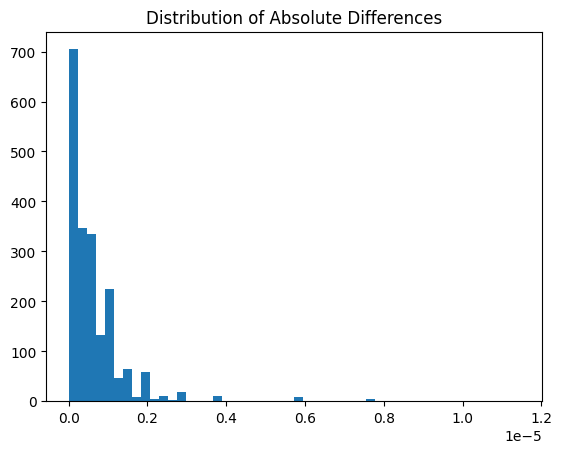

In [29]:
import matplotlib.pyplot as plt

diff = np.abs(emb_0_0_torch - emb_0_0_cmodel)

plt.hist(diff.flatten(), bins=50)
plt.title('Distribution of Absolute Differences')
plt.show()


In [30]:
mismatched_elements = np.where(np.abs(emb_0_0_torch - emb_0_0_cmodel) > 1)
print("Mismatched indices:", mismatched_elements)
print("Number of mismatched elements:", len(mismatched_elements[0]))


Mismatched indices: (array([], dtype=int64), array([], dtype=int64))
Number of mismatched elements: 0


In [31]:
torch_emb[20]

array([  0.4898109 ,  -3.5757718 ,   1.4103858 ,   3.602018  ,
        11.062615  ,  -2.090833  ,   0.49077818,   3.9046898 ,
        -1.2333556 ,  -2.0952313 ,  -3.8670776 ,   1.514319  ,
        -0.82082117,  -3.179889  ,  -2.537966  ,   3.6468947 ,
        17.990564  ,   0.65527385,  -1.0845667 ,  -1.6969988 ,
        -0.04109223,  -0.17623505,   8.021975  ,  -0.12078911,
        -2.5774014 ,  -1.0443853 , -12.383506  ,  -1.369188  ,
        -2.7794058 ,  -1.232136  ,  -3.7453022 ,   0.5690581 ],
      dtype=float32)

In [32]:
cmodel_emb[20]

array([  0.4898109 ,  -3.575771  ,   1.4103858 ,   3.6020193 ,
        11.062614  ,  -2.0908332 ,   0.49077788,   3.9046898 ,
        -1.2333561 ,  -2.0952313 ,  -3.8670774 ,   1.5143193 ,
        -0.8208209 ,  -3.1798894 ,  -2.5379658 ,   3.6468947 ,
        17.990566  ,   0.6552743 ,  -1.084567  ,  -1.6969985 ,
        -0.0410922 ,  -0.17623565,   8.021975  ,  -0.12078877,
        -2.5774016 ,  -1.0443854 , -12.383506  ,  -1.3691878 ,
        -2.7794056 ,  -1.2321355 ,  -3.7453022 ,   0.5690582 ],
      dtype=float32)

In [33]:
emb_0_0_torch[20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [34]:
emb_0_0_cmodel[20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

##### Find elements with no neighbors

In [35]:
has_neighbors = np.zeros(62)
numEdges = c_edge_index.shape[0]
for edge in range(numEdges):
    srcNode = c_edge_index[edge][0]
    has_neighbors[srcNode] = 1

In [36]:
np.where(has_neighbors < 1)

(array([20, 22, 26, 40, 43, 47, 48, 59, 60, 61]),)

##### emb_0_1 

In [37]:
np.testing.assert_allclose(torch_model.graphnet.emb_0_1_.cpu().numpy(), cmodel.get_emb_0_1(), rtol=1e-5)

AssertionError: 
Not equal to tolerance rtol=1e-05, atol=0

Mismatched elements: 10 / 1984 (0.504%)
Max absolute difference: 4.5776367e-05
Max relative difference: 4.1729796e-05
 x: array([[ 5.703845e+01, -6.796918e+01, -3.869891e+01, ..., -7.309753e+01,
        -2.358881e+01, -2.045426e+01],
       [ 2.144717e+01, -2.971880e+01, -7.679878e+00, ..., -2.963979e+01,...
 y: array([[ 5.703848e+01, -6.796917e+01, -3.869892e+01, ..., -7.309753e+01,
        -2.358882e+01, -2.045426e+01],
       [ 2.144717e+01, -2.971880e+01, -7.679879e+00, ..., -2.963979e+01,...

##### emb1 = emb + emb_0_1

In [38]:
np.testing.assert_allclose(torch_model.graphnet.emb1_.cpu().numpy(), cmodel.get_emb1(), rtol=1e-5)

AssertionError: 
Not equal to tolerance rtol=1e-05, atol=0

Mismatched elements: 11 / 1984 (0.554%)
Max absolute difference: 4.5776367e-05
Max relative difference: 9.2706636e-05
 x: array([[ 59.652412, -79.16496 , -27.798458, ..., -77.65717 , -29.682947,
        -24.325756],
       [ 25.755352, -40.37539 ,  -0.502232, ..., -31.738771,  -3.264416,...
 y: array([[ 59.652443, -79.164955, -27.798468, ..., -77.65717 , -29.682951,
        -24.325748],
       [ 25.755356, -40.375385,  -0.502233, ..., -31.738777,  -3.264411,...

In [ ]:
# torch_emb1 = torch_model.graphnet.emb1_.cpu().numpy()
# c_emb1 = cmodel.get_emb1()
# print(torch_emb1.shape)
# print(c_emb1.shape)

In [ ]:
# print("c_emb1 has inf:", np.isinf(c_emb1).any())

In [ ]:
# print(torch_emb1)

In [ ]:
# print(c_emb1)

In [ ]:
# ar_x, ar_y = np.where(np.isinf(c_emb1))
# print(ar_x.shape)
# print(ar_y.shape)
# print(ar_x)
# print(ar_y)
# nodes_wo = np.unique(ar_x)
# print(f'Nodes without neighbors: {nodes_wo}')
# print(f'Number of nodes without neighbors: {len(nodes_wo)}')

In [ ]:
# torch_emb1[187][28]

In [ ]:
# c_emb1[187][28]

In [ ]:
# print(np.where(edge_index_np == 24))
# print(torch_emb[24])
# print(torch_emb1[24])

In [ ]:
# np.where(edge_index_np == 187)

##### emb_1_0 

In [39]:
np.testing.assert_allclose(torch_model.graphnet.emb_1_0_.cpu().numpy(), cmodel.get_emb_1_0(), rtol=1e-5)

AssertionError: 
Not equal to tolerance rtol=1e-05, atol=0

Mismatched elements: 38 / 1984 (1.92%)
Max absolute difference: 2.2888184e-05
Max relative difference: 0.00243486
 x: array([[ 44.741283,  25.49674 ,  17.02134 , ..., -93.10888 , -29.496044,
        -66.66221 ],
       [ 18.79072 ,   8.425501,   8.644247, ..., -26.153965, -10.529826,...
 y: array([[ 44.741306,  25.49674 ,  17.021353, ..., -93.10887 , -29.496025,
        -66.66221 ],
       [ 18.790716,   8.425503,   8.644248, ..., -26.153967, -10.529824,...

##### emb_1_1 

In [40]:
np.testing.assert_allclose(torch_model.graphnet.emb_1_1_.cpu().numpy(), cmodel.get_emb_1_1(), rtol=1e-5)

AssertionError: 
Not equal to tolerance rtol=1e-05, atol=0

Mismatched elements: 53 / 1984 (2.67%)
Max absolute difference: 9.918213e-05
Max relative difference: 0.0009215
 x: array([[ 1.673367e+02,  9.899960e+01,  3.124129e+01, ..., -1.322985e+02,
        -1.987338e+01, -1.306570e+02],
       [ 7.053487e+01,  3.301241e+01,  1.579787e+01, ..., -3.743993e+01,...
 y: array([[ 1.673368e+02,  9.899960e+01,  3.124132e+01, ..., -1.322985e+02,
        -1.987337e+01, -1.306570e+02],
       [ 7.053485e+01,  3.301241e+01,  1.579787e+01, ..., -3.743993e+01,...

##### emb2 = emb1 + emb_1_1

In [41]:
np.testing.assert_allclose(torch_model.graphnet.emb2_.cpu().numpy(), cmodel.get_emb2(), atol=1e-5)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=1e-05

Mismatched elements: 77 / 1984 (3.88%)
Max absolute difference: 0.00012207
Max relative difference: 0.00016937
 x: array([[ 2.269891e+02,  1.983464e+01,  3.442837e+00, ..., -2.099557e+02,
        -4.955633e+01, -1.549827e+02],
       [ 9.629022e+01, -7.362984e+00,  1.529563e+01, ..., -6.917870e+01,...
 y: array([[ 2.269893e+02,  1.983464e+01,  3.442854e+00, ..., -2.099557e+02,
        -4.955632e+01, -1.549827e+02],
       [ 9.629021e+01, -7.362976e+00,  1.529564e+01, ..., -6.917871e+01,...

In [ ]:
# # Calculate Euclidean distance
# arr1 = torch_model.graphnet.emb2_.cpu().numpy()
# arr2 = cmodel.get_emb2()
# print(arr1.shape)
# print(arr2.shape)
# # euclidean_distance = np.linalg.norm(torch_model.graphnet.emb2_.cpu().numpy() - cmodel.get_emb2())
# # print("Euclidean distance:", euclidean_distance)

# mse = np.mean((arr1 - arr2) ** 2)
# print("Mean Squared Error:", mse)

#### Test Final Result

In [42]:
np_results = results.detach().cpu().numpy()
print(np_results)

[0.         0.         0.         0.         1.2113011  0.82256913
 2.6447513  2.7712681  2.6262352  0.         0.         0.
 0.         0.         0.         1.4684341  3.8509257  0.20476615
 0.         2.089573   0.5622525  0.         0.3277741  5.278312
 2.472635   0.5085514  0.6205317  2.696421   0.32120833 7.2954345
 0.         4.203053   4.466446   7.8641257  4.818085   0.
 0.         0.         0.10690206 0.         0.43448648 0.5281205
 0.67292595 0.47426623 0.         0.         0.6493745  0.40555972
 0.63529265 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.34175476 0.56449234
 0.         0.        ]


##### Relu activation

In [43]:
np.testing.assert_allclose(np_results, cmodel.get_output(), rtol=1e-5)

### Other Tests

In [ ]:
# import c_radius_graph

# # Example points in 2D space and their corresponding batch indices
# points = [[0.0, 0.0], [1.0, 1.0], [2.0, 2.0],  # Batch 0
#           [3.0, 3.0], [4.0, 4.0],              # Batch 1
#           [5.0, 5.0], [6.0, 6.0]]              # Batch 2
# batch_indices = [0, 0, 0, 1, 1, 2, 2]  # Batch assignments
# radius = 1.5

In [ ]:
# # Call the C++ function
# neighbors = c_radius_graph.find_neighbors_by_batch(points, batch_indices, radius)

# # Print neighbors
# for pair in neighbors:
#     print(f"Point {pair[0]} is within radius of point {pair[1]}")

# neighbors

In [ ]:
# points_tensor = torch.tensor(points)
# batch_tensor = torch.tensor(batch_indices)

# edge_index_pts = radius_graph(points_tensor, r=radius, batch=batch_tensor, loop=False, max_num_neighbors=255)

In [ ]:
# print(edge_index_pts)

In [ ]:
# # Example usage in Python
# import graphmetnetwork_bindings as gmn

# # Create an instance of the model
# model = gmn.GraphMetNetwork()

# # Load the weights
# model.load_weights("path_to_weights_file.txt")

# # Now, you can run the model with input data
# for i, (x_cont, x_cat, edge_index, batch) in enumerate(dataloader):
#     num_nodes = x_cont.shape[0]

#     # Run the PyTorch model
#     with torch.no_grad():
#         output = torch_model(x_cont.squeeze(0), x_cat.squeeze(0), edge_index.squeeze(0), batch.squeeze(0))

#     # Run the C++ model
#     model.GraphMetNetworkLayer(x_cont.squeeze(0).numpy(), x_cat.squeeze(0).numpy(), num_nodes, batch.squeeze(0).numpy())

#     # Compare intermediate values as before
#     np.testing.assert_allclose(torch_model._emb_cont.numpy(), model.get_emb_cont(), rtol=1e-5)
#     np.testing.assert_allclose(torch_model._emb_chrg.numpy(), model.get_emb_chrg(), rtol=1e-5)
#     np.testing.assert_allclose(torch_model._emb_pdg.numpy(), model.get_emb_pdg(), rtol=1e-5)
#     np.testing.assert_allclose(torch_model._emb_cat.numpy(), model.get_emb_cat(), rtol=1e-5)
#     np.testing.assert_allclose(torch_model._emb.numpy(), model.get_emb(), rtol=1e-5)
#     np.testing.assert_allclose(torch_model._emb1.numpy(), model.get_emb1(), rtol=1e-5)
#     np.testing.assert_allclose(torch_model._emb2.numpy(), model.get_emb2(), rtol=1e-5)
#     np.testing.assert_allclose(output.numpy(), model.get_output(), rtol=1e-5)
